# Linear Neural Network - Logistic Regression (Linearly Non-Separable Data)


In this notebook, we formulate the Logistic Regression technique for binary classification as a Linear Neural Network (LNN) model. 

Using the LNN model, we perform binary classification on a **linearly non-separable** dataset (i.e., the Iris dataset). After training, we visualize the decision boundary to assess how well the model distinguishes between the two classes.

#### Note that we don't use a separate test set to evaluate the model's performance. Our goal here is to introduce how LNNs can be constructed and trained using the TensorFlow Keras API.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

## Decision Boundary: Using Various Thresholds for a Class Probability

We define a function to show the decision boundaries at various thresholds of a class probability. Using the different estimates for a single class, we generate a contour plot. 

In [2]:
def decision_boundary_class_colored(clf, X):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points    
    y_pred_proba = clf.predict(X_new).reshape(x1.shape)

    y_pred = y_pred_proba
            
    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if(y_pred_proba[i][j] >= 0.5):
                y_pred[i][j] = 1
            else:
                y_pred[i][j] = 0
        
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)

## Synthetic Dataset: Linearly Separable


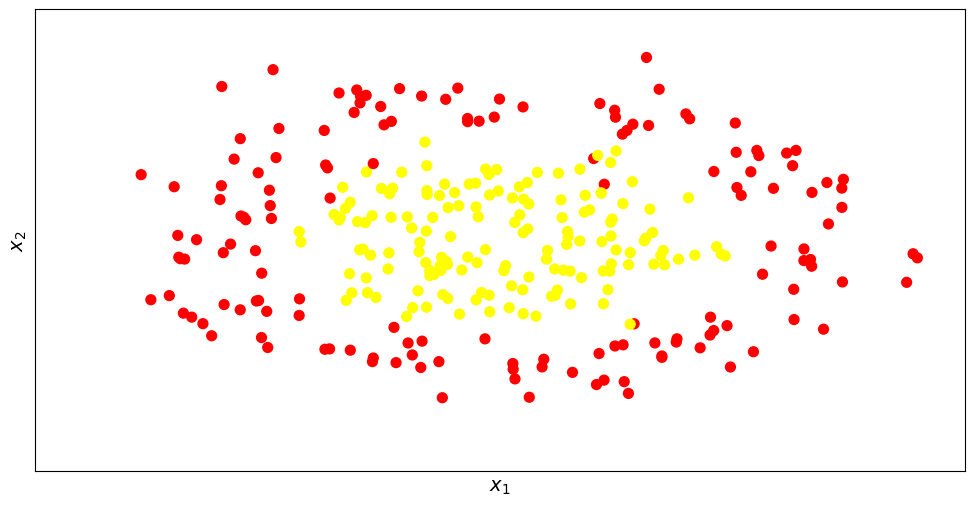

In [3]:
X, y = make_circles(300, factor=0.4, noise=0.15)

label = y

plt.figure(figsize=(12, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

#plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.axis([-1.5, 1.5, -1.7, 1.7])
plt.xticks(())
plt.yticks(())
plt.show()

## Create a LNN Model

Using the Keras Dense layer we create a LNN model for Logistic Regression. **In a Dense layer, each neuron is connected to all inputs/neurons of the previous layer**.

The LNN model:
- has only one neuron.
- uses the logistic sigmoid function.

First, we need to specify the shape of the input using the Input layer, which instantiates a Keras tensor—a symbolic TensorFlow tensor.
- The "shape" parameter is a tuple of integers that defines the dimensionality of the input vectors. In this demo, the input is a 2D vector, so we use the tuple (2,). For image classification tasks, where inputs are matrices (e.g., a 28x28 image), the "shape" tuple would be (28, 28). Alternatively, if we flatten the input matrix (28x28=784), we would use the tuple (784,) to represent the dimensions of the flattened vector. Note that the batch size is not included in the shape definition.

Dense layer:
- kernel_initializer: we initialize the weights (also known as the kernel) with zero values. In logistic/softmax regression, initial zero weight values are ok. However, in nonlinear neural networks, such as Multi-layer Perceptron (MLPs), we must use small random values to initialize the weights. For that, we need to use sophisticated initializers, such as glorot or he.
- activation: we use logistic sigmoid


#### The commented-out dense layer with 4 neurons is used to show that by building a Multi-layer Perceptron (MLP), we can create a nonlinear decision boundary.

In [4]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise, memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = tf.keras.models.Sequential(name="LNN_Binary_Classifier")
model.add(tf.keras.layers.Input(shape=[2,]))
#model.add(tf.keras.layers.Dense(units=4, kernel_initializer="he_normal", activation="relu"))
model.add(tf.keras.layers.Dense(units=1, kernel_initializer="zeros", activation="sigmoid"))

model.summary()

Model: "LNN_Binary_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
CPU times: user 48.5 ms, sys: 3.24 ms, total: 51.7 ms
Wall time: 16.4 ms


## Compile & Train the LNN Model

A Keras model automatically employs the **backpropagation** algorithm to train an artificial neural network (ANN). However, we need to specify an optimization algorithm.

There are various advanced optimizers available, but for our LNN, we will use the **stochastic gradient descent (SGD)** optimizer, which requires setting an appropriate learning rate.

We will implement mini-batch SGD, so it's essential to specify both the batch size and the number of epochs.

### History Object
To monitor the performance of our model during training, we will utilize the tf.keras.callbacks.History object. This object automatically tracks key metrics, such as loss and accuracy, for each epoch across both training and validation datasets.

The History object is automatically applied when a model is trained using the fit() method in TensorFlow Keras. It records metrics, including:
- Loss for both training and validation data.
- Accuracy (or other metrics) for both training and validation data.

By analyzing this recorded history, we can assess the effectiveness of our training process and make necessary adjustments.

In [5]:
'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.9)


'''
Compile the model
'''
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
The History object is applied when a model is trained using the fit() method.
It automatically tracks the performance of a model during training. 
It records key metrics such as loss and accuracy for each epoch, for both training and validation data.
'''
history = model.fit(X, #  Feature data
                    y, # Target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
                   )

Epoch 1/50
5/5 [==============================] - 0s 724us/step - loss: 0.6947 - accuracy: 0.4000
Epoch 2/50
5/5 [==============================] - 0s 488us/step - loss: 0.6949 - accuracy: 0.4800
Epoch 3/50
5/5 [==============================] - 0s 489us/step - loss: 0.6942 - accuracy: 0.4433
Epoch 4/50
5/5 [==============================] - 0s 591us/step - loss: 0.6964 - accuracy: 0.4767
Epoch 5/50
5/5 [==============================] - 0s 474us/step - loss: 0.6942 - accuracy: 0.4433
Epoch 6/50
5/5 [==============================] - 0s 471us/step - loss: 0.6950 - accuracy: 0.4500
Epoch 7/50
5/5 [==============================] - 0s 506us/step - loss: 0.6967 - accuracy: 0.5733
Epoch 8/50
5/5 [==============================] - 0s 515us/step - loss: 0.6950 - accuracy: 0.4733
Epoch 9/50
5/5 [==============================] - 0s 486us/step - loss: 0.6949 - accuracy: 0.4333
Epoch 10/50
5/5 [==============================] - 0s 454us/step - loss: 0.6972 - accuracy: 0.4433
Epoch 11/50
5/5 [==

2024-09-21 11:43:50.718270: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 26/50
5/5 [==============================] - 0s 435us/step - loss: 0.6951 - accuracy: 0.4533
Epoch 27/50
5/5 [==============================] - 0s 366us/step - loss: 0.6951 - accuracy: 0.4867
Epoch 28/50
5/5 [==============================] - 0s 453us/step - loss: 0.6959 - accuracy: 0.4900
Epoch 29/50
5/5 [==============================] - 0s 483us/step - loss: 0.6957 - accuracy: 0.4833
Epoch 30/50
5/5 [==============================] - 0s 442us/step - loss: 0.6955 - accuracy: 0.4133
Epoch 31/50
5/5 [==============================] - 0s 410us/step - loss: 0.6950 - accuracy: 0.4933
Epoch 32/50
5/5 [==============================] - 0s 446us/step - loss: 0.6976 - accuracy: 0.5033
Epoch 33/50
5/5 [==============================] - 0s 375us/step - loss: 0.6951 - accuracy: 0.5100
Epoch 34/50
5/5 [==============================] - 0s 431us/step - loss: 0.6955 - accuracy: 0.4800
Epoch 35/50
5/5 [==============================] - 0s 374us/step - loss: 0.6946 - accuracy: 0.4633
Epoch 36/5

## Evaluate the LNN Model

In [6]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)


# Display training performance metrics (accuracy and loss)
print("\nTrain Loss & Accuracy: ", model.evaluate(X, y, verbose=0))


'''
Compute the accuracy
'''
# Predict the probabilities for each sample
y_predicted_proba = model.predict(X)

# Create a prediction array with the same shape as the predicted probability array.
y_predicted = np.zeros(y_predicted_proba.shape)

# Get the predictions from the probabilities
for i in range(len(y_predicted)):
    if(y_predicted_proba[i] >= 0.5):
        y_predicted[i] = 1
    else:
        y_predicted[i] = 0


# Flattens the 2D prediction array into a 1D array.
y_predicted = y_predicted.ravel()

# Compute the accuracy from the true and predicted target values
accuracy = np.mean(y_predicted == y)

print("\nAccuracy: ", accuracy)

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_predicted))

print("\nClassification Report:")
print(classification_report(y, y_predicted))

Epochs:  50

Train Loss & Accuracy:  [0.6932669878005981, 0.5899999737739563]
10/10 [==============================] - 0s 209us/step

Accuracy:  0.59

Confusion Matrix:
[[ 27 123]
 [  0 150]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.18      0.31       150
           1       0.55      1.00      0.71       150

    accuracy                           0.59       300
   macro avg       0.77      0.59      0.51       300
weighted avg       0.77      0.59      0.51       300



## Plot The Decision Boundary

313/313 [==============================] - 0s 174us/step


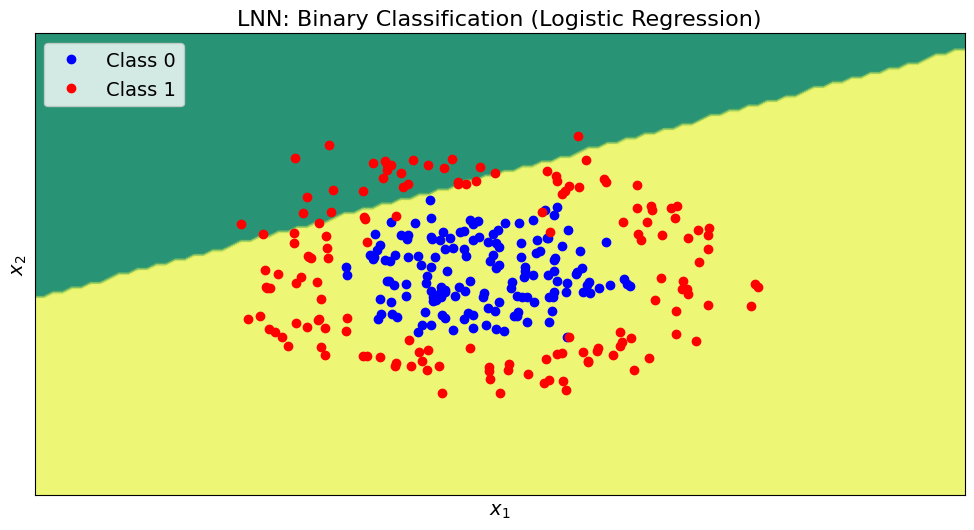

In [7]:
plt.figure(figsize=(12, 6))    

decision_boundary_class_colored(model, X)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Binary Classification (Logistic Regression)", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()